In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, json

In [3]:
path_to_data = "/home/basti/Dropbox (UiO)/MEK3700/data/"

dataset = "brain2dclipp1"

# Read and show binary masks

In [4]:
brainmask = np.load(path_to_data + dataset +  "/masks/mask.npy")
box = np.load(path_to_data + dataset +  "/masks/box.npy")

roi = brainmask * box

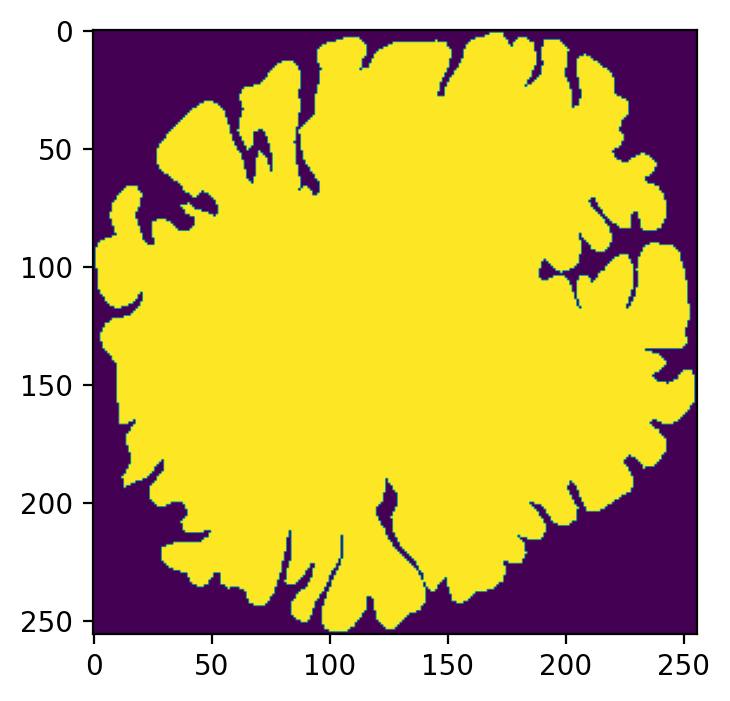

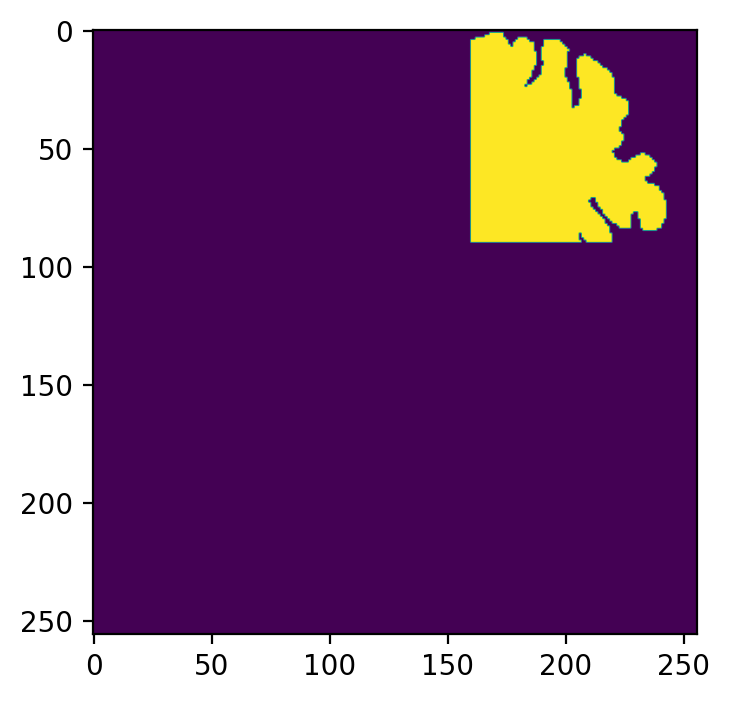

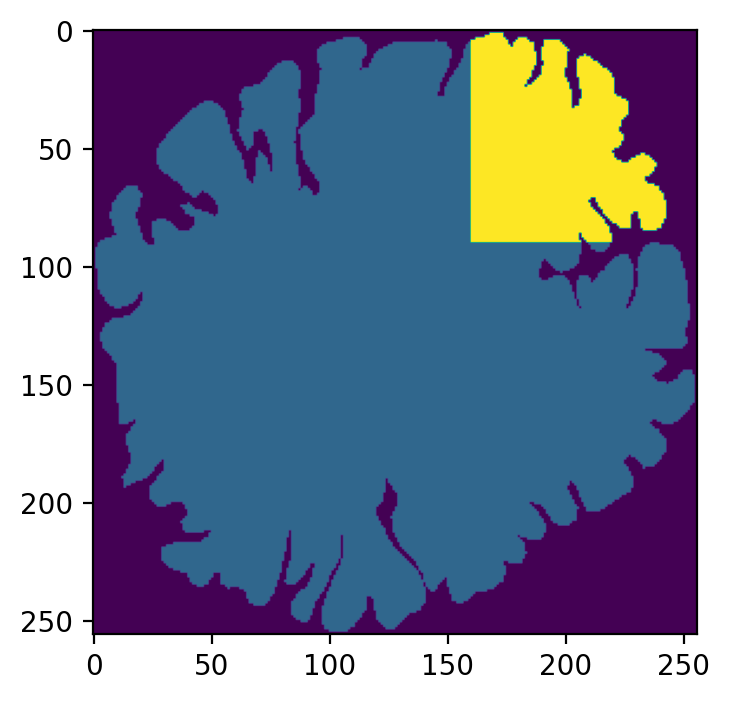

In [5]:
plt.figure(dpi=200)
plt.imshow(brainmask)
plt.show()

plt.figure(dpi=200)
plt.imshow(roi)
plt.show()

plt.figure(dpi=200)
plt.imshow(brainmask + 2 * roi)
plt.show()

# Read images to dict

In [6]:
def load_images(path_to_data, dataset):
    path_to_concentrations = path_to_data + dataset +  "/concentrations/"
    
    images = {}
    
    for cfile in os.listdir(path_to_concentrations):
        
        c = np.load(path_to_concentrations + cfile)
        
        images[cfile[:-4]] = c
        
    return images
    

In [7]:
images = load_images(path_to_data, dataset)

In [8]:
images.keys()

dict_keys(['00.00', '07.20', '24.00', '19.20', '09.60', '26.40', '04.80', '21.60', '36.00', '45.60', '28.80', '14.40', '33.60', '43.20', '40.80', '12.00', '16.80', '02.40', '31.20', '38.40'])

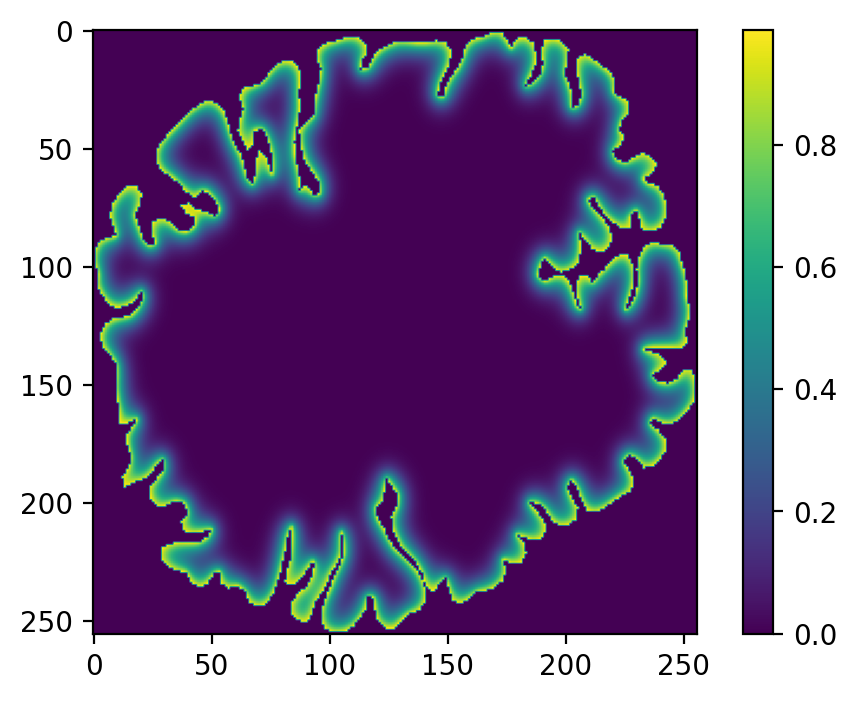

In [9]:
plt.figure(dpi=200)
plt.imshow(images["24.00"] * brainmask)
plt.colorbar()
plt.show()

# Use json and dicts to store parameters

In [10]:
param_dict ={"a": 1}
param_dict["b"] = 2

print("dict:", param_dict)
print("keys:", param_dict.keys())
print("items:", param_dict.items())
print("item a", param_dict["a"])

dict: {'a': 1, 'b': 2}
keys: dict_keys(['a', 'b'])
items: dict_items([('a', 1), ('b', 2)])
item a 1


In [11]:
exportfolder = "/home/basti/programming/pytorchdemo/"
with open(exportfolder + 'my_parameters.json', 'w') as fp:
    json.dump(param_dict, fp, sort_keys=True, indent=4)
    
with open(exportfolder + 'my_parameters.json', 'r') as data_file:    
    loaded_dict = json.load(data_file)
    
print(param_dict)
print("Loaded back:", loaded_dict)

{'a': 1, 'b': 2}
Loaded back: {'a': 1, 'b': 2}


# Create spatial coordinates

We first create a 256x256x2 array where arr[i,j, :] = (x_i, y_i) is the position of voxel (i,j)

In [12]:
def make_coordinate_grid(images):
    """ Create a (n x n x 2) array where arr[i,j, :] = (x_i, y_i) is the position of voxel (i,j)"""
    n = 256

    # We want to assign coordinates to every voxel, so the shape of the meshgrid has to be the same as the image
    assert n == images[next(iter(images.keys()))].shape[0]
    assert n == images[next(iter(images.keys()))].shape[1]
    
    coordinate_axis = np.linspace(-0.5, 0.5, n)
    
    XX, YY = np.meshgrid(coordinate_axis, coordinate_axis, indexing='ij')
    
    arr = np.array([XX, YY])

    coordinate_grid = np.swapaxes(arr, 0, 1)
    coordinate_grid = np.swapaxes(coordinate_grid, 1, 2)
    
    return coordinate_grid

In [13]:
coordinate_grid = make_coordinate_grid(images)

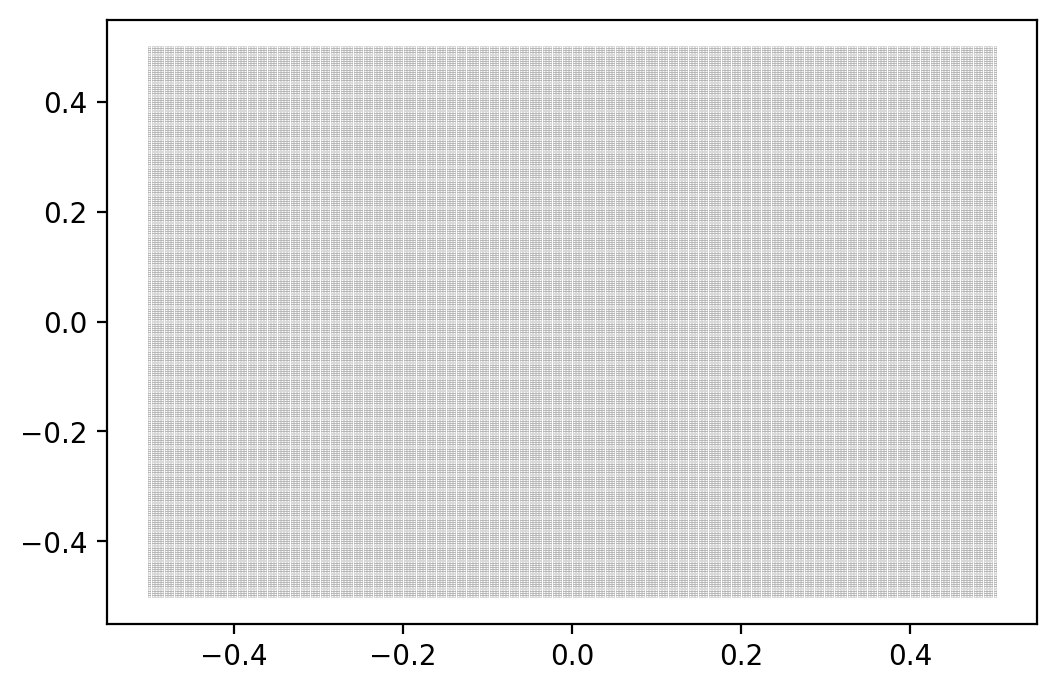

In [14]:
plt.figure(dpi=200)
plt.plot(coordinate_grid[..., 0], coordinate_grid[..., 1], marker=".", linewidth=0, markersize=0.1, color="k")
# plt.xlim(0, 0.1)
plt.show()

# Map out voxels inside the brain, and get only their coordinates as a list



In [15]:
def get_domain_coordinates(coordinate_grid, mask):
    return coordinate_grid[mask]   

In [16]:
xy = get_domain_coordinates(coordinate_grid, mask=brainmask)

In [17]:
def get_input_output_pairs(coordinate_grid, mask, images):
    
    input_output_pairs = {}
    
    xy = get_domain_coordinates(coordinate_grid, mask)
    
    for timekey, image in images.items():
        
        xyt = np.zeros((xy.shape[0], 3))
        xyt[..., :2] = xy
        xyt[..., -1] = float(timekey)
        
        input_output_pairs[timekey] = (xyt, image[mask])
        
    return input_output_pairs

In [18]:
datadict = get_input_output_pairs(coordinate_grid, mask=brainmask, images=images)

### xyt is an array where xyt[i,j, :] = (x_i, y_j, t)  (voxel coordinates at first two indices and time at last index)

In [19]:
# t = "00.00"
t = "24.00"
xyt = datadict[t][0]
data_at_t = datadict[t][1]

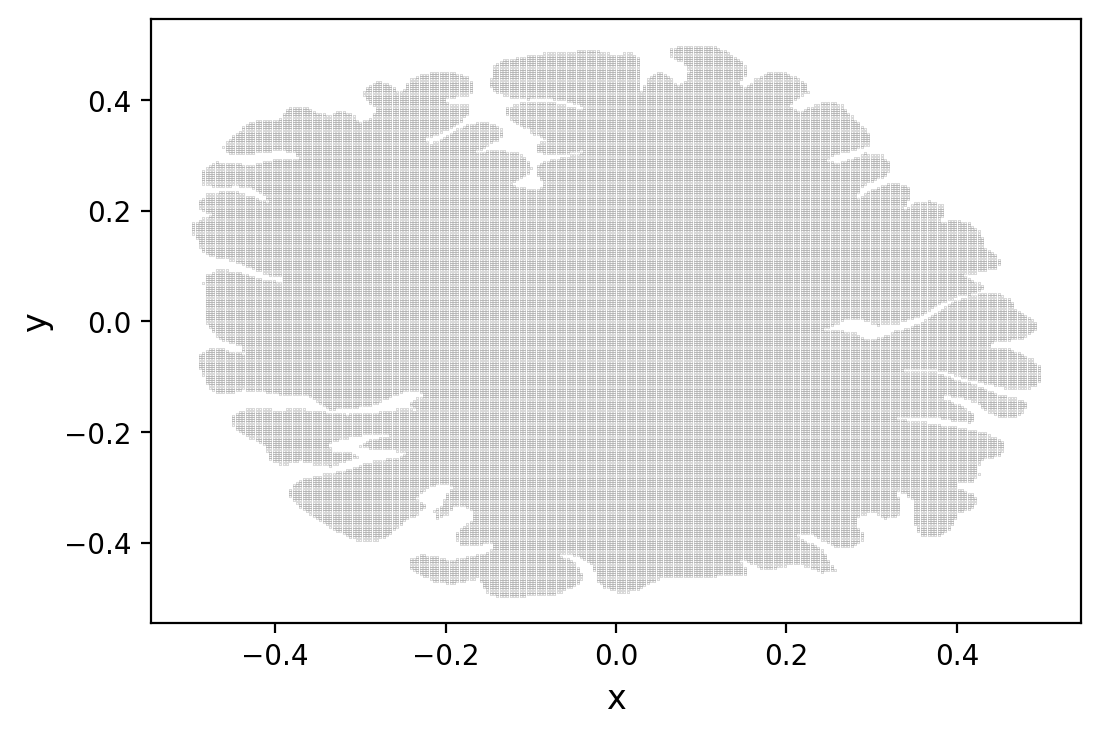

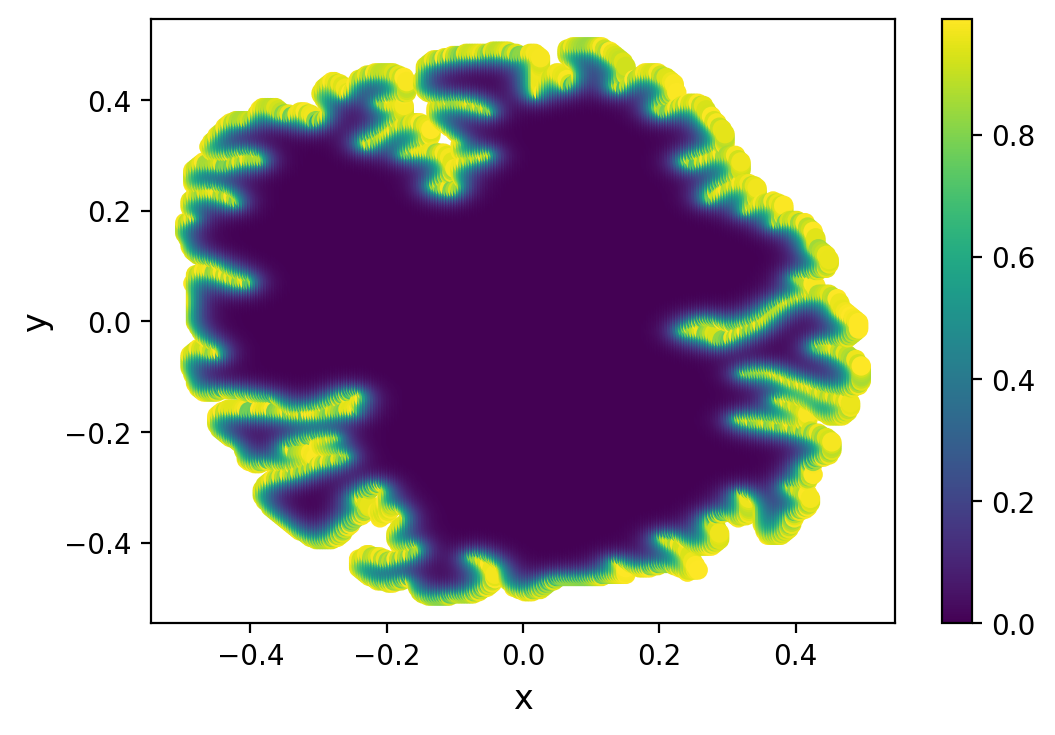

In [20]:
plt.figure(dpi=200)
plt.plot(xyt[..., 0], xyt[..., 1], marker=".", linewidth=0, markersize=0.1, color="k")
# plt.xlim(0, 0.1)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.show()

plt.figure(dpi=200)
plt.scatter(xyt[..., 0], xyt[..., 1], c=data_at_t)
# plt.xlim(0, 0.1)
plt.colorbar()
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.show()

# Do the same for the small region

In [21]:
datadict = get_input_output_pairs(coordinate_grid, mask=roi, images=images)
# t = "00.00"
t = "24.00"
xyt = datadict[t][0]
data_at_t = datadict[t][1]

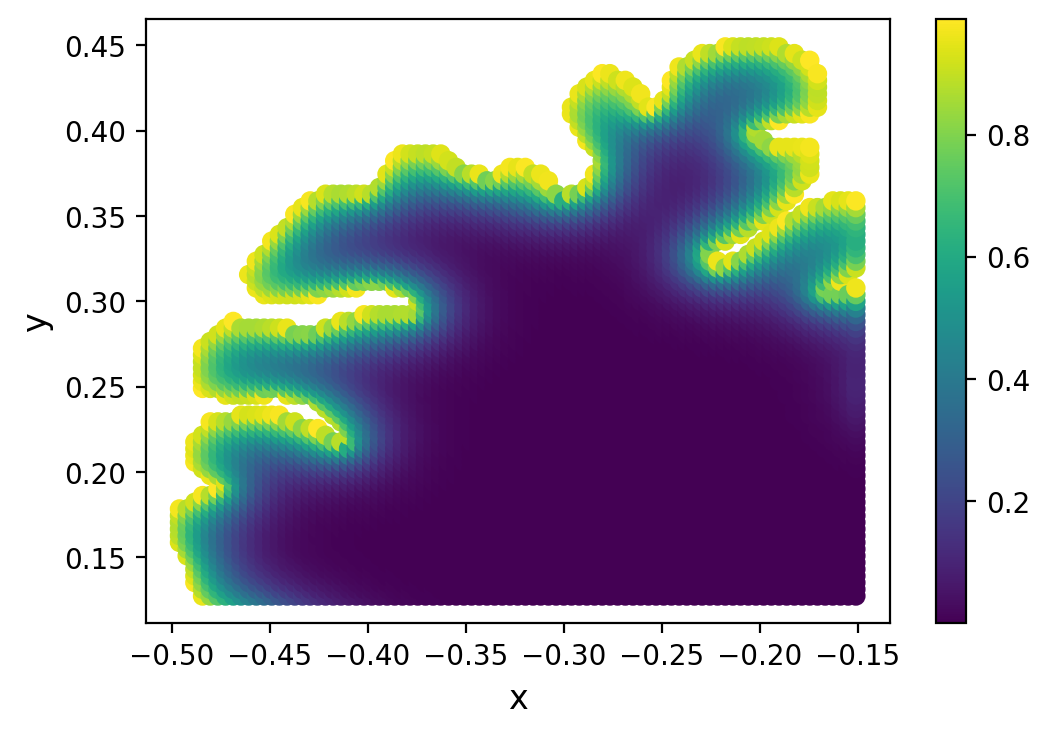

In [22]:
plt.figure(dpi=200)
plt.scatter(xyt[..., 0], xyt[..., 1], c=data_at_t)
# plt.xlim(0, 0.1)
plt.colorbar()
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.show()

# If you want to create PDE points, sample randomly in time:

In [23]:
n_pde = int(1e5)

In [24]:
def init_collocation_points(coords, num_points, t_max, t_min ):
    with torch.no_grad():

        assert len(coords.shape) == 2, "Assert mask has been applied"

        random_ints = torch.randint(high=coords.size(0), size=(num_points,), device=coords.device)    
        coords = coords[random_ints, :]
    
        a = (np.random.rand(coords.shape[0]))
        # a = lhs(1, coords.shape[0]).flatten().astype(float)
        random_times = torch.from_numpy(a).to(coords.device)
        t = (random_times * (t_max - t_min) + t_min)

        coords[..., -1] = t

        print("Initialized collocation points with mean t = ",
            format(torch.mean(t).item(), ".2f"),
            ", min t = ", format(torch.min(t).item(), ".2f"),
            ", max t = ", format(torch.max(t).item(), ".2f"))

    return coords

In [25]:
coords = torch.from_numpy(xyt)

In [26]:
tmax = float(max(datadict.keys()))
tmin = float(min(datadict.keys()))

In [27]:
pde_points = init_collocation_points(coords, num_points=int(1e6), t_max=tmax, t_min=tmin)

Initialized collocation points with mean t =  22.80 , min t =  0.00 , max t =  45.60


In [28]:
pde_points

tensor([[-0.3118,  0.3667, 36.9242],
        [-0.4059,  0.2294, 29.5052],
        [-0.4608,  0.2255, 16.4435],
        ...,
        [-0.2137,  0.2569,  1.1513],
        [-0.4294,  0.1745, 41.6807],
        [-0.3627,  0.2176, 15.5656]], dtype=torch.float64)

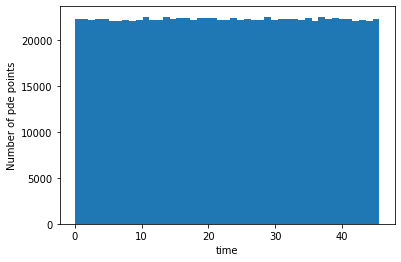

In [29]:
plt.hist(pde_points[..., -1].numpy(), bins=int(tmax))
plt.ylabel("Number of pde points")
plt.xlabel("time")
plt.show()

# Compute the PDE loss 

In [30]:
def pderesidual(coords, nn, D):
        """
        coords = pde_points
        nn = neural network
        D = diffusion coefficient
        
        """
        
        assert isinstance(D, torch.nn.Parameter)
        assert coords.shape[-1] == 3, "your array should have size N x 3"
        
        coords.requires_grad = True
        output = nn(coords).squeeze()

        ones = torch.ones_like(output)

        output_grad, = torch.autograd.grad(outputs=output,
                                        inputs=coords,
                                        grad_outputs=ones,
                                        create_graph=True)
        doutput_dt = output_grad[..., -1]
        doutput_dx = output_grad[..., 0]
        doutput_dy = output_grad[..., 1]
        
        ddoutput_dxx, = torch.autograd.grad(outputs=doutput_dx,
                                            inputs=coords,
                                            grad_outputs=ones,
                                            create_graph=True)

        ddoutput_dyy, = torch.autograd.grad(outputs=doutput_dy,
                                            inputs=coords,
                                            grad_outputs=ones,
                                            create_graph=True)

        ddoutput_dxx = ddoutput_dxx[..., 0]
        ddoutput_dyy = ddoutput_dyy[..., 1]

        laplacian = (ddoutput_dxx + ddoutput_dyy)

        residual = doutput_dt - D * laplacian

        assert output.shape == residual.shape

        return residual